In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/mobile_net_t0-val_acc=0.7706.ckpt'


Mounted at /content/drive


In [ ]:
!pip install  pytorch_lightning torchmetrics

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchmetrics
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import os
import glob
import shutil

sns.set()

In [6]:
class Model(pl.LightningModule):
    def __init__(self, output_units, dropout, learning_rate, freeze_base=False):
        super().__init__()
        self.base_model = torchvision.models.mobilenet_v2(pretrained=True)

        if freeze_base:
            for layer in self.base_model.features:
                for param in layer:
                    param.requires_grad = False

        self.base_model.classifier[0] = nn.Dropout(p=dropout)
        self.base_model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=output_units)

        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, input_data):
        return self.base_model(input_data)

    def training_step(self, batch, batch_nb):
        input_data, targets = batch
        preds = self(input_data)
        loss = self.criterion(preds, targets)
        self.log('train_loss', loss)
        self.train_acc(preds, targets)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_nb):
        input_data, targets = batch
        preds = self(input_data)
        loss = self.criterion(preds, targets)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_acc(preds, targets)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_nb):
        self.validation_step(batch, batch_nb)

    def predict_step(self, batch, batch_nb):
        input_data, targets = batch
        preds = self(input_data)
        return torch.argmax(preds, dim=1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
#Load checkpoint
NUM_CLASSES = 10
#Load Trained Model
model = Model.load_from_checkpoint(PATH)

model.eval()

In [8]:
import torch.nn as nn
import torch.optim as optim  
import torchvision.transforms as transforms
import torchvision
import os
from torchvision.io import decode_jpeg
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image

NUM_CLASSES = 10
BATCH_SIZE = 32
path = '/content/drive/MyDrive/dataset/'
os.chdir(path)
class CreateDataset(Dataset):
    def __init__(self, df,transform=False):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):   
        img_path = self.df.iloc[index, 0]
        image = read_image(img_path) / 255.0
        #print('/content/drive/MyDrive/dataset/'+img_path)
        label = self.df.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        return image, label
################
transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")
#print(val_df.head)

train_dataset=CreateDataset(train_df, transformers)
test_dataset=CreateDataset(test_df, transformers)
val_dataset=CreateDataset(val_df, transformers)
#####
def data_loader(batch_size):
  train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)
  val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False)
  return train_dataloader, test_dataloader, val_dataloader

In [9]:
from pytorch_lightning import Trainer
train_dataloader, test_dataloader, val_dataloader = data_loader(BATCH_SIZE)
trainer = pl.Trainer(gpus=1)
y_pred = trainer.predict(model , dataloaders=val_dataloader)
#trainer.test(model ,test_dataloaders=test_dataloader)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [10]:
y_pred_all = []
for y in y_pred:
  y_pred_all.extend(y.cpu().tolist())

In [11]:
val_df['pred'] = y_pred_all

val_df.to_csv('val_pred.csv', index=False)


In [12]:
val_pred_df = pd.read_csv('val_pred.csv')
val_pred_df.head()

,image_path,label,subject,source,pred
0,data/Camera 1/train/c0/1589.jpg,0,p11,Camera 1,0
1,data/Camera 1/train/c0/1590.jpg,0,p11,Camera 1,0
2,data/Camera 1/train/c0/1592.jpg,0,p11,Camera 1,0
3,data/Camera 1/train/c0/1593.jpg,0,p11,Camera 1,0
4,data/Camera 1/train/c0/1594.jpg,0,p11,Camera 1,0


In [13]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

accuracy_score(val_pred_df['label'], val_pred_df['pred'])

0.7706167706167706

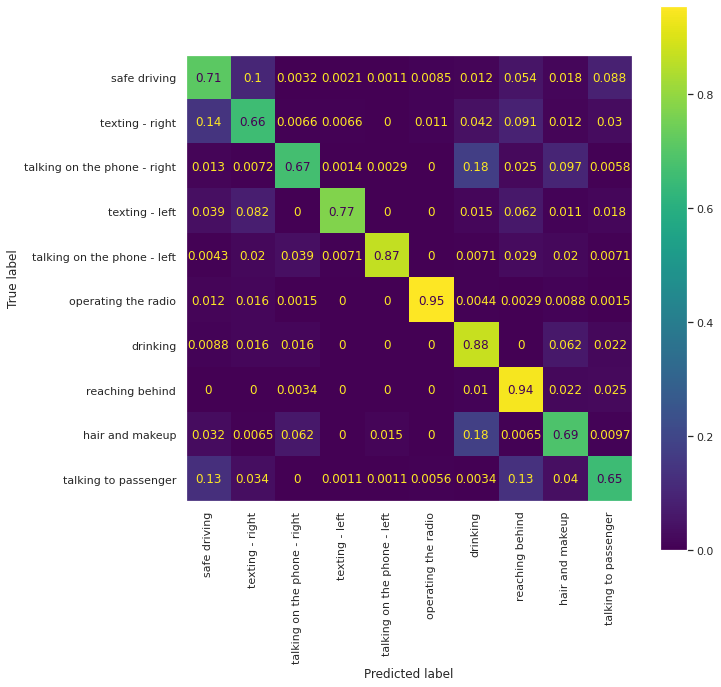

In [14]:
labels = [
    'safe driving',
    'texting - right',
    'talking on the phone - right',
    'texting - left',
    'talking on the phone - left',
    'operating the radio',
    'drinking',
    'reaching behind',
    'hair and makeup',
    'talking to passenger'
]

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(val_pred_df['label'], val_pred_df['pred'], 
                                        normalize='true', ax=ax, display_labels=labels,
                                        xticks_rotation='vertical'
                                       )
ax.grid(False)
plt.show()

In [15]:
val_pred_df['correct'] = (val_pred_df['label'] == val_pred_df['pred'])

accuracy_per_class = val_pred_df.groupby(['label'])['correct'].mean()
accuracy_per_class

label
0    0.712619
1    0.658278
2    0.670043
3    0.773414
4    0.867332
5    0.953216
6    0.875000
7    0.939292
8    0.687196
9    0.652418
Name: correct, dtype: float64

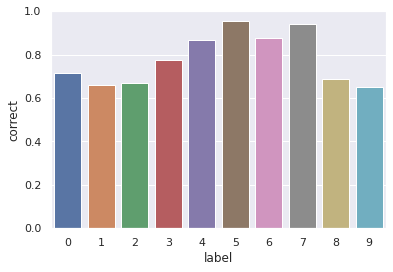

In [16]:
sns.barplot(x=accuracy_per_class.index, y=accuracy_per_class)

In [17]:
accuracy_per_subject = val_pred_df.groupby(['subject'], sort=True)['correct'].mean()
subject_count = val_pred_df.groupby(['subject'], sort=True)['correct'].count()
pd.DataFrame([subject_count, accuracy_per_subject])

subject,p021,p024,p039,p042,p050,p11,p17,p27,p28,p29,p34,p35,p36,p41
correct,1237.000000,1226.000000,651.000000,591.000000,790.000000,269.000000,346.000000,335.000000,531.000000,439.000000,200.00,200.00,200.000,200.00
correct,0.870655,0.806688,0.794163,0.927242,0.850633,0.724907,0.713873,0.408955,0.774011,0.510251,0.81,0.62,0.705,0.58


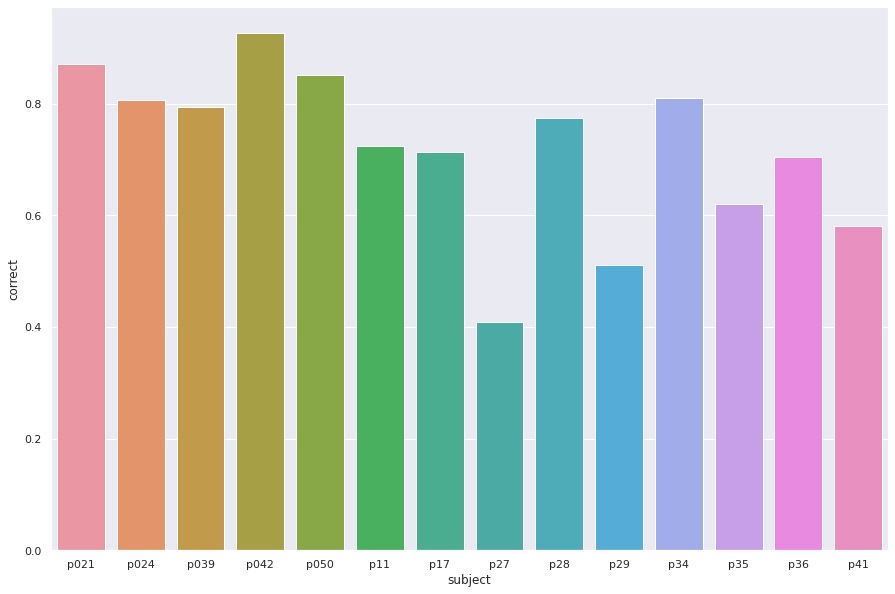

In [18]:
plt.figure(figsize=(15, 10))
sns.barplot(x=accuracy_per_subject.index, y=accuracy_per_subject)
plt.show()

In [19]:
accuracy_per_source = val_pred_df.groupby(['source'])['correct'].mean()
accuracy_per_source

source
Camera 1     0.632292
Camera 2     0.678750
StateFarm    0.846051
Name: correct, dtype: float64

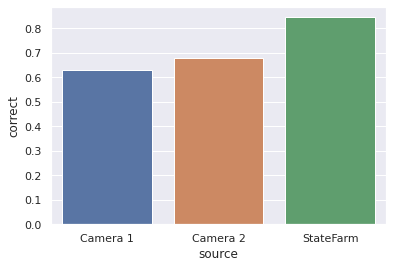

In [20]:
sns.barplot(x=accuracy_per_source.index, y=accuracy_per_source)
plt.show()

In [50]:
import glob
import shutil
import os

src_dir = '/content/drive/MyDrive/dataset/'
#os.chdir(path)
dst_dir = "/content/drive/MyDrive/dataset/MissClassified"

#val_pred_df[val_pred_df['correct'] == False]
miss =val_pred_df[val_pred_df['correct'] == False]
print(miss)
for p in miss['image_path']:
  for f in glob.iglob(os.path.join(src_dir,p )):
    shutil.copy(f, dst_dir)


                           image_path  label  ... correct missclassified
102   data/Camera 1/train/c0/2307.jpg    0.0  ...   False           True
117   data/Camera 1/train/c0/2346.jpg    0.0  ...   False           True
133   data/Camera 1/train/c0/2371.jpg    0.0  ...   False           True
137   data/Camera 1/train/c0/2376.jpg    0.0  ...   False           True
138   data/Camera 1/train/c0/2377.jpg    0.0  ...   False           True
...                               ...    ...  ...     ...            ...
7201  data/StateFarm/c9/img_96579.jpg    9.0  ...   False           True
7206  data/StateFarm/c9/img_97863.jpg    9.0  ...   False           True
7208  data/StateFarm/c9/img_98296.jpg    9.0  ...   False           True
7212  data/StateFarm/c9/img_99733.jpg    9.0  ...   False           True
7213  data/StateFarm/c9/img_99801.jpg    9.0  ...   False           True

[1655 rows x 7 columns]
